<span style="font-size: 25pt; font-weight: bold;"><span style="color: #0098cd;">Actividad 2:</span> Exploración de filtros espaciales y morfológicos en escenarios reales</span>

_Authors:_ Araceli Ruiz Vallecillo, Fernando Fuentes Carrasco, Javier Jordán Luque and Teodoro Hidalgo Guerrero



***
### Libraries
***

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

***
### Global Functions
***

In [51]:
# Function to add salt and pepper noise
def add_salt_pepper(image, salt_probability=0.2, pepper_probability=0.2):
    noisy_image = image.copy()
    total_pixels = image.size

    # Add salt
    num_salt = int(salt_probability * total_pixels)
    salt_indices = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    noisy_image[salt_indices[0], salt_indices[1]] = 255

    # Add pepper
    num_pepper = int(pepper_probability * total_pixels)
    pepper_indices = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
    noisy_image[pepper_indices[0], pepper_indices[1]] = 0

    return noisy_image

***
### Pipeline #1 (Car Plate Detection)
***

In [52]:
def preprocess_image(image_path):
    # Read and convert the image to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define structuring element
    structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

    # Perform morphological open and close operations
    open_img = cv2.morphologyEx(gray, cv2.MORPH_OPEN, structuring_element)
    close_img = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, structuring_element, iterations=2)

    return gray, open_img, close_img

def generate_mroi_map(open_img, close_img, block_size=(15, 5)):
    # Compute standard deviation maps
    h, w = open_img.shape
    block_h, block_w = block_size
    map_h, map_w = h // block_h, w // block_w

    open_dev_map = np.zeros((map_h, map_w))
    close_dev_map = np.zeros((map_h, map_w))

    for i in range(map_h):
        for j in range(map_w):
            # Define block region
            block = slice(i * block_h, (i + 1) * block_h), slice(j * block_w, (j + 1) * block_w)
            open_dev_map[i, j] = np.std(open_img[block])
            close_dev_map[i, j] = np.std(close_img[block])

    # Generate MROI map using the formula
    mroi_map = (open_dev_map + 1) / (close_dev_map + 1)
    return open_dev_map,close_dev_map,mroi_map

def binarize_mroi_map(mroi_map, exclude_percentile=95):
    # Calculate histogram and threshold
    normalized = cv2.normalize(mroi_map, None, 0, 255, cv2.NORM_MINMAX)
    normalized = normalized.astype(np.uint8)

    threshold = np.percentile(normalized, exclude_percentile)
    binary_map = cv2.threshold(normalized, threshold, 255, cv2.THRESH_BINARY)[1]

    return binary_map

def remove_noise(binary_map):
    # Apply noise removal using connectivity check
    kernel = np.ones((1, 1), np.uint8)
    cleaned_map = cv2.morphologyEx(binary_map, cv2.MORPH_OPEN, kernel)
    return cleaned_map

def remove_white_pixels_outside_radius(image):
    # Get the dimensions of the image
    height, width = image.shape
    radius = max(height, width) // 4

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Create a mask with the same dimensions as the image
    mask = np.zeros((height, width), dtype=np.uint8)

    # Iterate through each pixel
    for y in range(height):
        for x in range(width):
            # Calculate the distance from the center
            distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

            # If the distance is within the radius, keep the pixel white
            if distance <= radius:
                mask[y, x] = 255

    # Apply the mask to the image
    result = cv2.bitwise_and(image, mask)

    return result

def printSingleImg(img, title = '', cmap = None):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.title(title)
    plt.show()

# PIPELINE #1 (CAR PLATE DETECTION)
def detect_plate(image_path, debug=False):
    # Load the image
    image = cv2.imread(image_path)
    if debug:
        printSingleImg(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'Original')

    # Preprocess the image
    gray, open_img, close_img = preprocess_image(image_path)
    if debug:
        printSingleImg(gray, 'Gray image', 'gray')

    # Generate the MROI map
    open,close,mroi_map = generate_mroi_map(open_img, close_img)

    if debug:
        printSingleImg(open_img, 'Open', 'gray')
    if debug:
        printSingleImg(open, 'Open Map', 'gray')

    if debug:
        printSingleImg(close_img, 'Close', 'gray')
    if debug:
        printSingleImg(close, 'Close Map', 'gray')

    if debug:
        printSingleImg(mroi_map, 'MROI Map', 'gray')

    # Binarize the MROI map
    binary_map = binarize_mroi_map(mroi_map)
    if debug:
        printSingleImg(binary_map, 'Binary Map (Pre-clean)', 'gray')

    # Keep only pixels which are half of the radius from the center
    cleaned_map = remove_white_pixels_outside_radius(binary_map.astype(np.uint8))
    if debug:
        printSingleImg(cleaned_map, 'Binary Map (Radius mask)', 'gray')

    # Merge the white pixels which are close to each other but keeping almost the original form
    kernel = np.ones((3, 3), np.uint8)
    cleaned_map = cv2.morphologyEx(cleaned_map, cv2.MORPH_CLOSE, kernel, iterations=1)
    if debug:
        printSingleImg(cleaned_map, 'Binary Map (Radius mask + Close)', 'gray')

    # Resize the cleaned map to the original image size
    resized_cleaned_map = cv2.resize(cleaned_map, (image.shape[1], image.shape[0]))
    if debug:
        printSingleImg(resized_cleaned_map, 'Binary Map (Radius mask + Close + Resized)', 'gray')

    # Detect the contours of the license plate
    contours, _ = cv2.findContours(resized_cleaned_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if aspect_ratio > 1.5 and aspect_ratio < 6:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    printSingleImg(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'Detected License Plate')

#### Playground

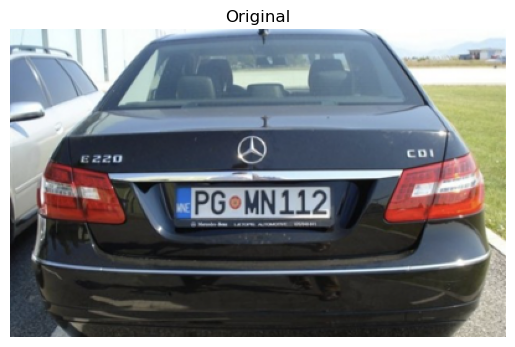

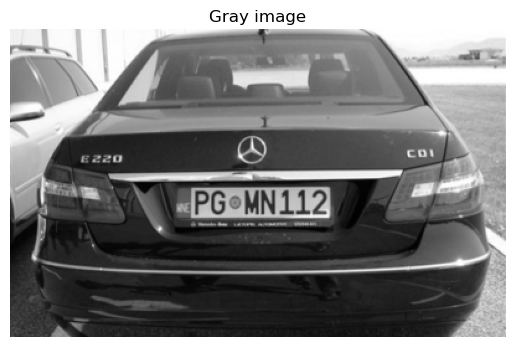

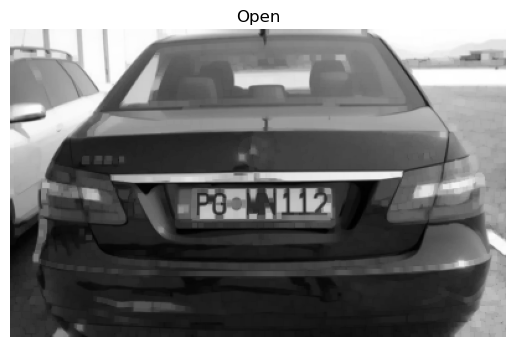

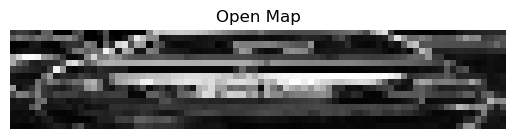

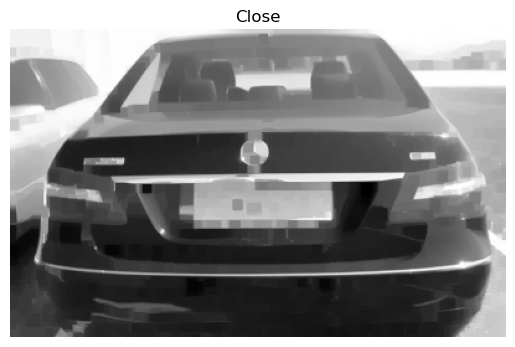

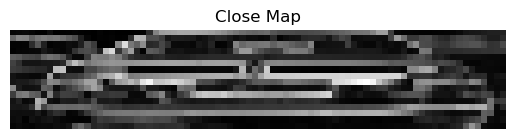

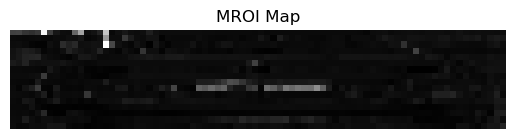

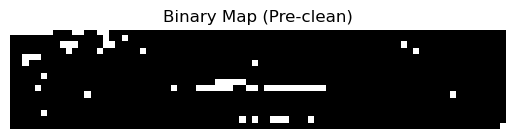

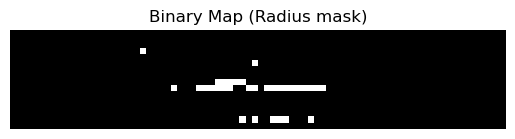

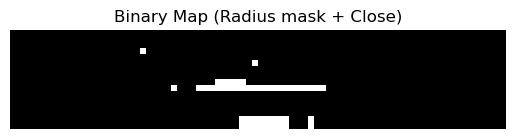

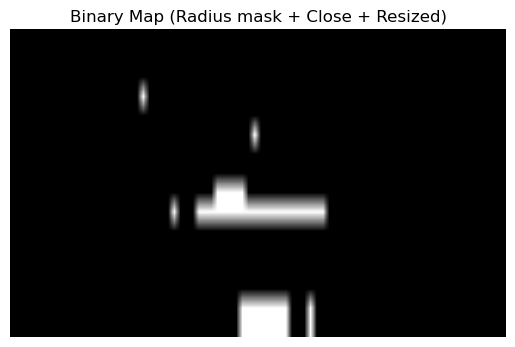

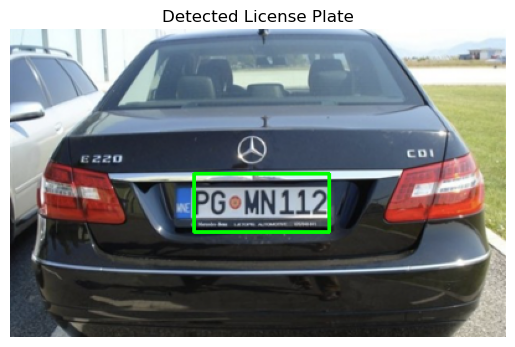

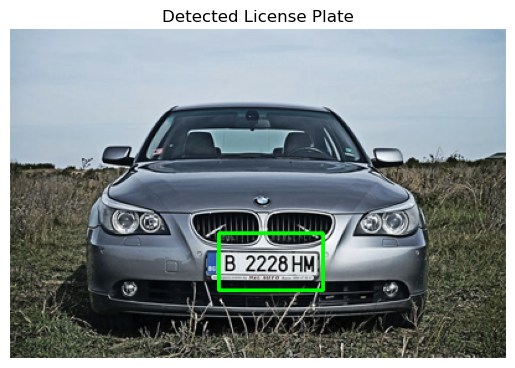

In [53]:
detect_plate("data/car1.png", debug=True)
detect_plate("data/car2.png")

***
### Pipeline #2 (Fingerprint Isolation)
***

In [54]:
# PIPELINE #2 (FINGERPRINT ISOLATION)
def fingerprint_isolation_pipeline(image_fingerprint):

    # Step 1: Apply median filter
    image_median = cv2.medianBlur(image_fingerprint, 5)

    # Step 2: Apply erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_eroded = cv2.erode(image_median, kernel, iterations=1)

    # Step 3: Improve contrast
    image_equalized = cv2.equalizeHist(image_eroded)

    # Step 4: Threshold the image to get a binary image
    _, image_thresholded = cv2.threshold(image_equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 5: Detect fingerprint contour
    contours, _ = cv2.findContours(image_thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5.1 Filter contours by area
    min_area = 1000  # Defines the minimum area for the contours to consider
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

    # Step 5.2. Exclude the largest contour (which is typically the image border)
    if filtered_contours:
        largest_contour = max(filtered_contours, key=cv2.contourArea)
        filtered_contours = [contour for contour in filtered_contours if cv2.contourArea(contour) != cv2.contourArea(largest_contour)]

    # Step 5.3. Draw the filtered contours on the eroded image
    image_contoured = cv2.drawContours(image_eroded.copy(), filtered_contours, -1, (0, 255, 0), 3)

    # Step 6. Isolate de fingerprint
    # Step 6.1. Create a completely white image
    image_isolated = np.ones_like(image_fingerprint) * 255

    # Step 6.2. Create a black mask (where the contours will be white)
    mask = np.zeros_like(image_fingerprint)

    # Step 6.3. Draw the filtered contours on the mask
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Step 6.2. Copy the pixels inside the contours into the white image
    image_isolated[mask == 255] = image_fingerprint[mask == 255]

    return image_median, image_eroded, image_equalized, image_thresholded, image_contoured, image_isolated

#### Playground

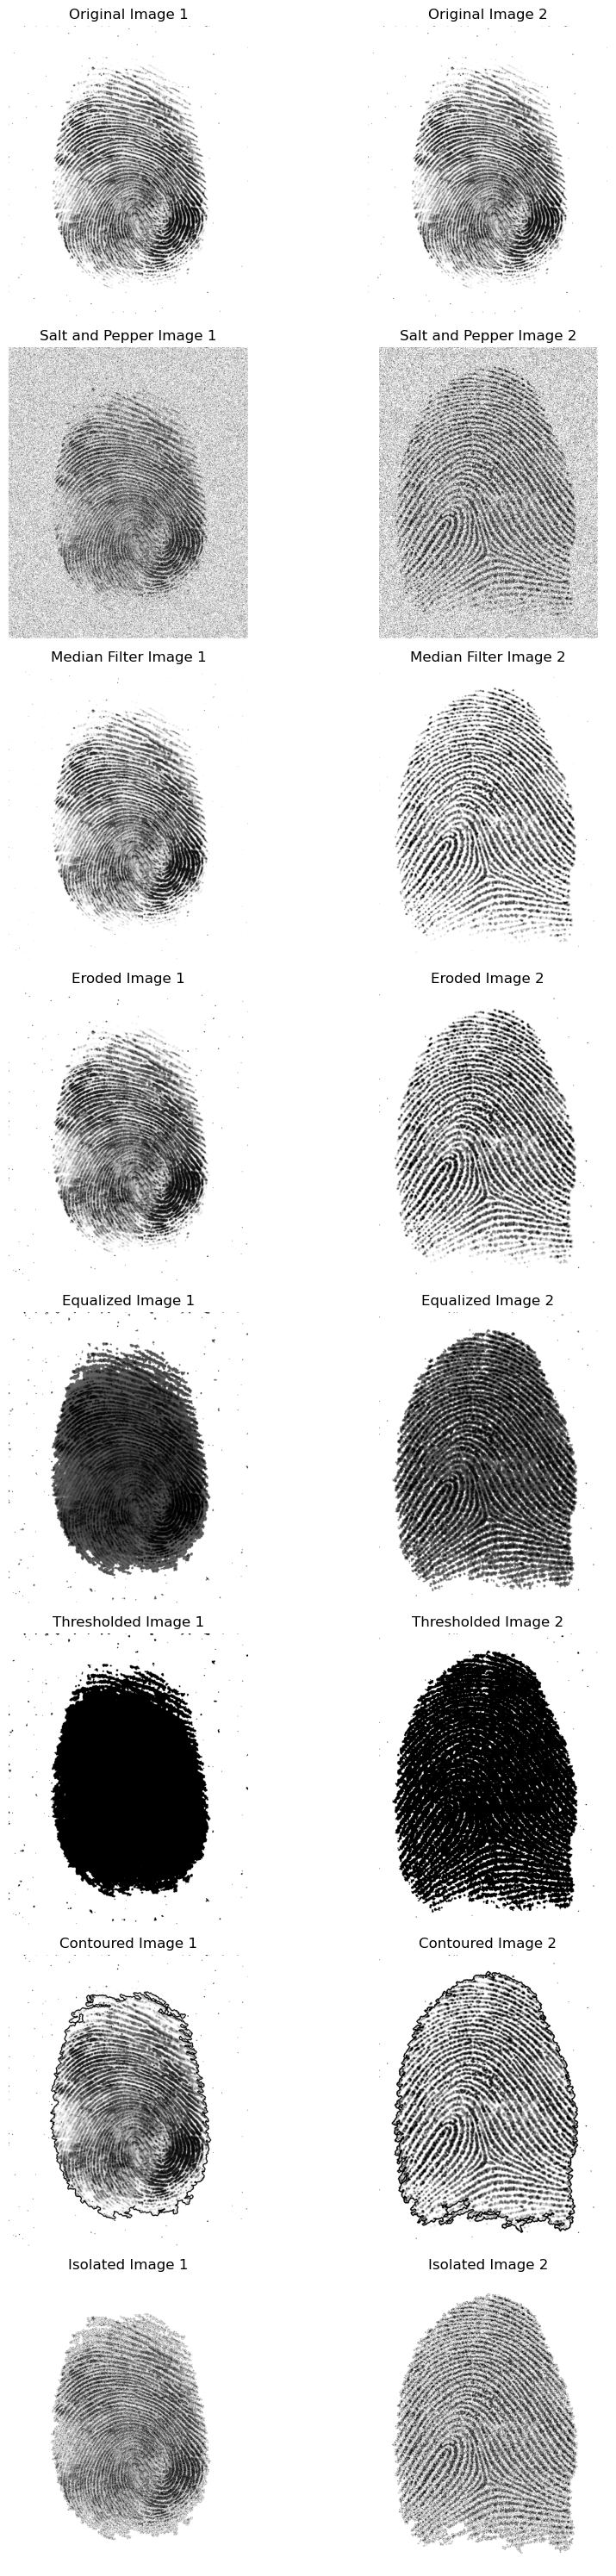

In [55]:
# Load the image
image_fingerprint1 = cv2.imread('data/fingerprint1.jpg', cv2.IMREAD_GRAYSCALE)
image_fingerprint2 = cv2.imread('data/fingerprint2.jpg', cv2.IMREAD_GRAYSCALE)

# Add salt and pepper noise
image_noise1 = add_salt_pepper(image_fingerprint1)
image_noise2 = add_salt_pepper(image_fingerprint2)

# Apply the fingerprint isolation pipeline
image_median1, image_eroded1, image_equalized1, image_thresholded1, image_contoured1, image_isolated1 = fingerprint_isolation_pipeline(image_noise1)
image_median2, image_eroded2, image_equalized2, image_thresholded2, image_contoured2, image_isolated2 = fingerprint_isolation_pipeline(image_noise2)

# Show the steps involved in the pipeline process
fig, axes = plt.subplots(8, 2, figsize=(10, 30))

axes[0, 0].imshow(image_fingerprint1, cmap='gray')
axes[0, 0].set_title('Original Image 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_fingerprint1, cmap='gray')
axes[0, 1].set_title('Original Image 2')
axes[0, 1].axis('off')

axes[1, 0].imshow(image_noise1, cmap='gray')
axes[1, 0].set_title('Salt and Pepper Image 1')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_noise2, cmap='gray')
axes[1, 1].set_title('Salt and Pepper Image 2')
axes[1, 1].axis('off')

axes[2, 0].imshow(image_median1, cmap='gray')
axes[2, 0].set_title('Median Filter Image 1')
axes[2, 0].axis('off')

axes[2, 1].imshow(image_median2, cmap='gray')
axes[2, 1].set_title('Median Filter Image 2')
axes[2, 1].axis('off')

axes[3, 0].imshow(image_eroded1, cmap='gray')
axes[3, 0].set_title('Eroded Image 1')
axes[3, 0].axis('off')

axes[3, 1].imshow(image_eroded2, cmap='gray')
axes[3, 1].set_title('Eroded Image 2')
axes[3, 1].axis('off')

axes[4, 0].imshow(image_equalized1, cmap='gray')
axes[4, 0].set_title('Equalized Image 1')
axes[4, 0].axis('off')

axes[4, 1].imshow(image_equalized2, cmap='gray')
axes[4, 1].set_title('Equalized Image 2')
axes[4, 1].axis('off')

axes[5, 0].imshow(image_thresholded1, cmap='gray')
axes[5, 0].set_title('Thresholded Image 1')
axes[5, 0].axis('off')

axes[5, 1].imshow(image_thresholded2, cmap='gray')
axes[5, 1].set_title('Thresholded Image 2')
axes[5, 1].axis('off')

axes[6, 0].imshow(image_contoured1, cmap='gray')
axes[6, 0].set_title('Contoured Image 1')
axes[6, 0].axis('off')

axes[6, 1].imshow(image_contoured2, cmap='gray')
axes[6, 1].set_title('Contoured Image 2')
axes[6, 1].axis('off')

axes[7, 0].imshow(image_isolated1, cmap='gray')
axes[7, 0].set_title('Isolated Image 1')
axes[7, 0].axis('off')

axes[7, 1].imshow(image_isolated2, cmap='gray')
axes[7, 1].set_title('Isolated Image 2')
axes[7, 1].axis('off')

plt.tight_layout()
plt.show()

***
### Pipeline #3 (Garbage Detection)
***

In [56]:
def pipeline_residuos(image_path):
    # Cargar la imagen desde el path
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen desde la ruta: {image_path}")

    # Convertir la imagen a RGB para su visualización correcta
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    copy_img = image.copy()
    imgs = [(image_rgb, None, 'Original')]  # Mostrar la imagen original sin modificaciones

    # Convertir la imagen a HSV para mejor filtrado por color
    hsv = cv2.cvtColor(copy_img, cv2.COLOR_BGR2HSV)

    # Rango de color para el color rojo en HSV
    lower_red1 = np.array([0, 50, 50])  # Rango de rojo bajo
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])  # Rango de rojo alto
    upper_red2 = np.array([180, 255, 255])

    # Crear máscaras para los dos rangos de rojo
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combinar las dos máscaras
    mask = cv2.bitwise_or(mask1, mask2)

    # Aplicar la máscara a la imagen original
    result = cv2.bitwise_and(copy_img, copy_img, mask=mask)

    # Convertir el resultado para mostrar en RGB
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Suavizado Gaussiano para reducir ruido
    gaussiano = cv2.GaussianBlur(result_rgb, (5, 5), 1.5)

    # Detección de bordes con Canny (ajustar umbrales según el tamaño del residuo)
    canny = cv2.Canny(gaussiano, 50, 150)  # Ajuste de umbrales de Canny

    # Operadores morfológicos con diferentes tamaños de kernel
    kernel = np.ones((5, 5), np.uint8)  # Kernel más grande para una dilatación más fuerte
    dilated = cv2.dilate(canny, kernel, iterations=3)  # Ampliar los bordes de los residuos
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=3)  # Cerrar los huecos

    # Detección de contornos
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una copia para dibujar el rectángulo
    image_with_contour = image_rgb.copy()

    # Buscar el contorno de mayor área y dibujarlo
    if contours:
        # Filtrar los contornos pequeños (eliminando ruido)
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]  # Solo contornos grandes

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)  # Contorno de mayor área

            # Dibujar el contorno de mayor área en un color muy visible (por ejemplo, rojo brillante)
            x, y, w, h = cv2.boundingRect(largest_contour)
            cv2.rectangle(image_with_contour, (x, y), (x + w, y + h), (0, 255, 255), 3)  # Rectángulo amarillo

    # Mostrar imágenes intermedias y el resultado final
    imgs.append((result_rgb, None, 'Filtro de Color y Aplicación de Máscara'))
    imgs.append((gaussiano, None, 'Suavizado Gaussiano'))
    imgs.append((canny, 'gray', 'Filtro Canny'))
    imgs.append((dilated, 'gray', 'Dilatación'))
    imgs.append((closed, 'gray', 'Clausura'))
    imgs.append((image_with_contour, None, 'Residuo Detectado'))

    return imgs

def mostrarImagenes(pipeline_result):
    """Muestra las imágenes procesadas con títulos y layout ajustado."""
    plt.figure(figsize=(15, 10))
    for i, (img, cmap, title) in enumerate(pipeline_result):
        plt.subplot(3, 3, i + 1)  # Cambiar a 3x3 para poner las 7 imágenes
        plt.imshow(img if cmap is None else img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Playground

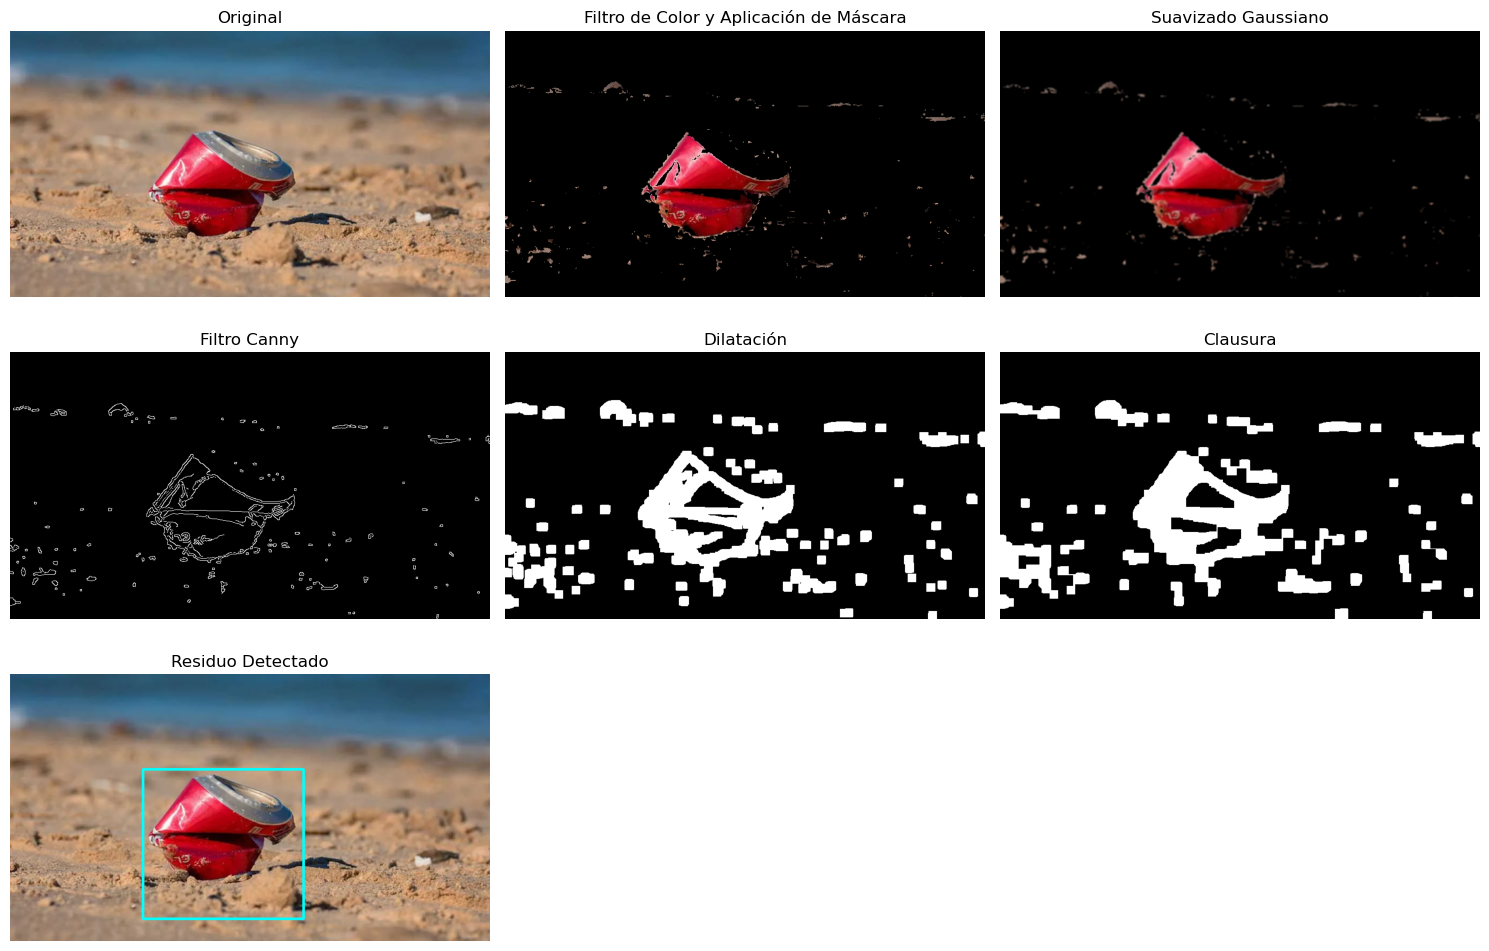

In [57]:
mostrarImagenes(pipeline_residuos('data/garbage.jpg'))

***
### Pipeline #4 (Planet Detection)
***

In [58]:
# Función para convertir BGR a HEX
def bgr_to_hex(bgr_color):
    r, g, b = int(bgr_color[2]), int(bgr_color[1]), int(bgr_color[0])
    return "#{:02x}{:02x}{:02x}".format(r, g, b)


def planet_detection_pipeline(image):
    # Paso 1: Eliminar ruido con filtro de mediana
    denoised_image_median = cv2.medianBlur(image, 5)  # Tamaño del kernel es 5

    # Paso 2: Segmentación basada en bordes y contornos en lugar de color
    # Convertir a escala de grises para resaltar características estructurales
    gray_image = cv2.cvtColor(denoised_image_median, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro de desenfoque para reducir el ruido
    blurred_gray = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Detección de bordes (Canny)
    edges = cv2.Canny(blurred_gray, 50, 150)

    # Encontrar contornos para identificar regiones de interés
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una imagen en blanco para dibujar los contornos segmentados
    segmentation_result = np.zeros_like(denoised_image_median)
    cv2.drawContours(segmentation_result, contours, -1, (0, 255, 0), 2)

    # Identificar el contorno más grande basado en el área
    largest_contour = max(contours, key=cv2.contourArea)

    # Calcular las dimensiones del rectángulo delimitador
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calcular la relación w/h
    aspect_ratio = w / h

    # Crear una máscara para el contorno más grande
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Calcular el color promedio dentro del contorno más grande
    mean_color = cv2.mean(denoised_image_median, mask=mask[:])
    mean_bgr = mean_color[:3]  # Solo tomar los valores B, G, R
    mean_hex = bgr_to_hex(mean_bgr)  # Convertir a HEX

    # Resaltar el contorno más grande en la imagen segmentada
    highlighted_image = denoised_image_median.copy()
    cv2.drawContours(highlighted_image, [largest_contour], -1, (0, 0, 255), 2)

    # Mostrar la muestra de color promedio
    plt.figure(figsize=(2, 2))
    plt.imshow([[np.array(mean_bgr[::-1]) / 255]])  # Invertir a RGB y normalizar a [0,1]
    plt.axis('off')
    plt.title(f"Color Sample: {mean_hex}")
    plt.show()
    print(f"################## Extración de Características ##################")
    print(f"Mean Color (BGR): {mean_bgr}")
    print(f"Mean Color (HEX): {mean_hex}")
    print(f"Aspect Ratio (w/h): {aspect_ratio}")

    # Clasificación de madurez según el color promedio
    def classify_planet(mean_color, aspect_ratio):
        # Convertir BGR a HSV para una mejor clasificación basada en tono
        bgr_array = np.uint8([[list(mean_color)]])
        hsv_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2HSV)[0][0]
        hue = hsv_array[0]
        print(f"Tono HSV: {hue}")

        # Clasificaciones basadas en el tono (Hue en HSV)
        if 12 <= hue < 20:  # Tonos rojos/amarillos (Es Venus)
            return "Es Venus"
        elif 20 <= hue < 30:  # Tonos rojos/amarillos (Puede ser Venus)
            return "Puede ser Venus"
        elif 30 <= hue <= 150:  # Tonos amarillos/verdosos/azulados (No son Venus)
            return "NO es Venus"
        else:
            return "Desconocido"

    # Calcular la clasificación de madurez
    planet_class = classify_planet(mean_bgr, aspect_ratio)

    # Imprimir el resultado
    print(f"################## Toma de Decisiones ##################")
    print(f"Planet Classification: {planet_class}")

    return denoised_image_median, edges, highlighted_image

#### Playground

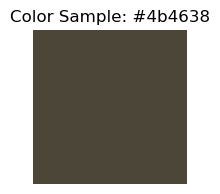

################## Extración de Características ##################
Mean Color (BGR): (56.73818270879256, 70.97256918932158, 75.64829782023023)
Mean Color (HEX): #4b4638
Aspect Ratio (w/h): 1.0253439536567706
Tono HSV: 22
################## Toma de Decisiones ##################
Planet Classification: Puede ser Venus


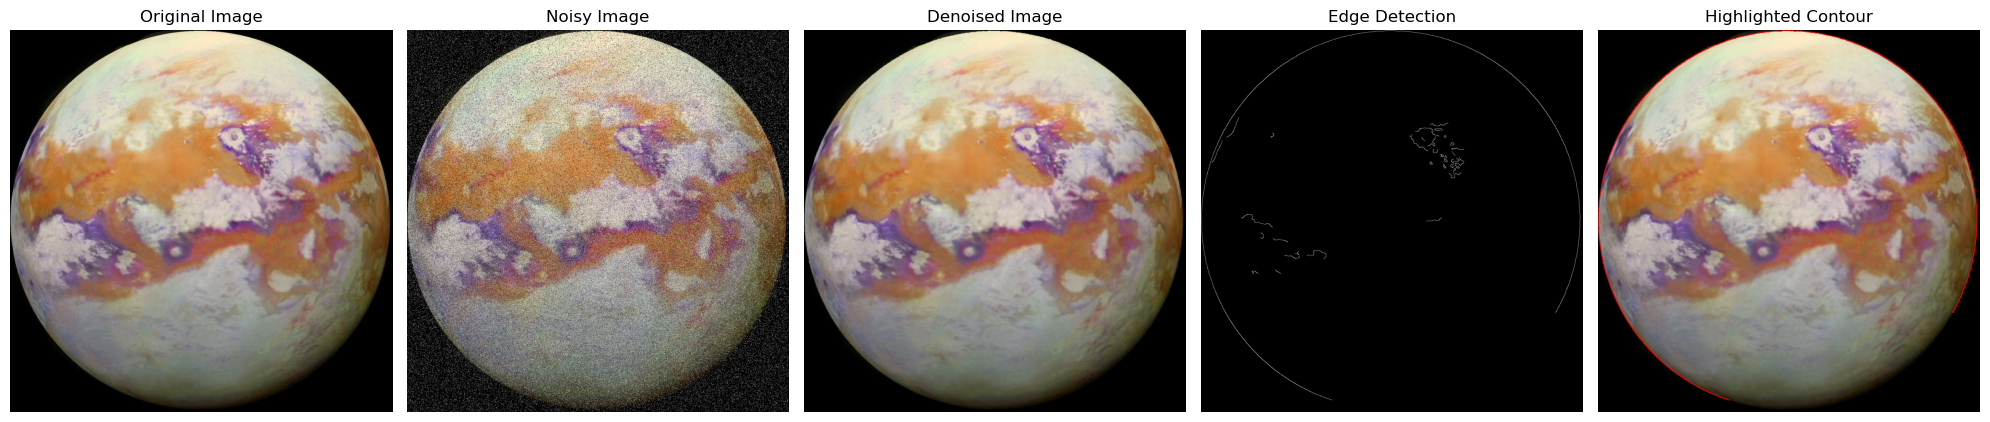

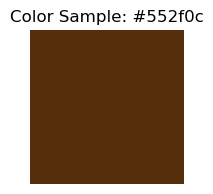

################## Extración de Características ##################
Mean Color (BGR): (12.705343511450382, 47.1618320610687, 85.52773536895674)
Mean Color (HEX): #552f0c
Aspect Ratio (w/h): 0.9961832061068703
Tono HSV: 14
################## Toma de Decisiones ##################
Planet Classification: Es Venus


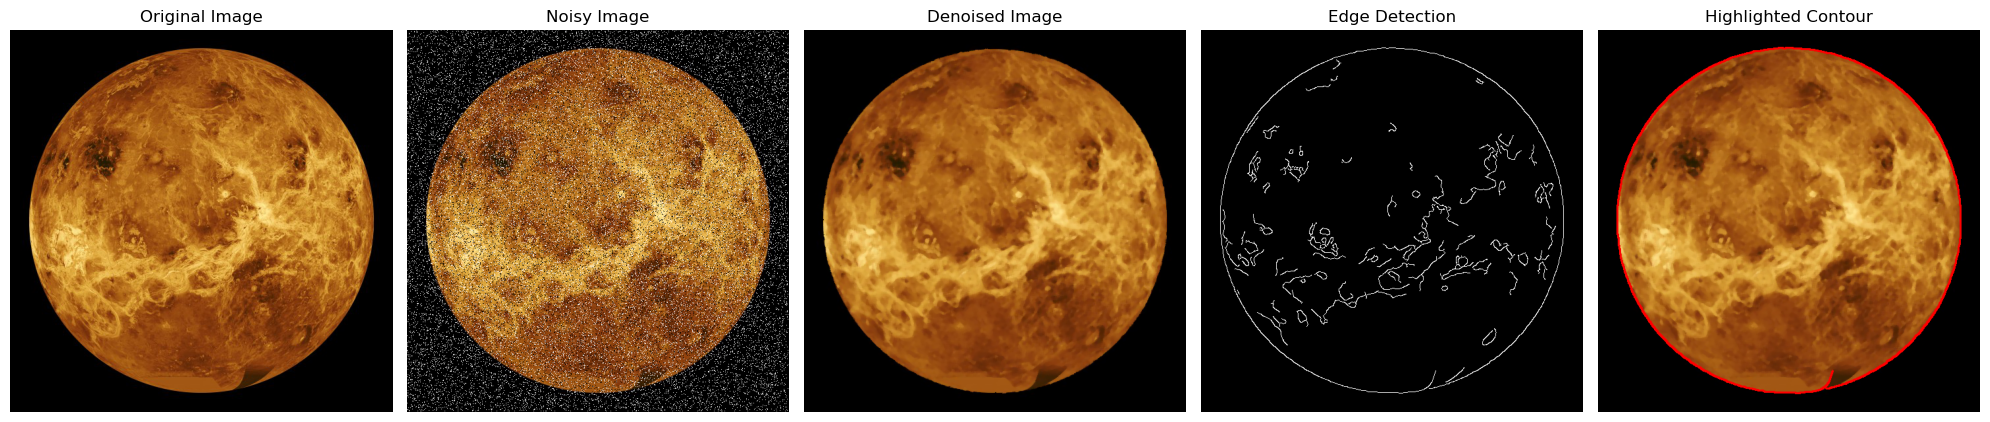

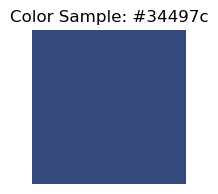

################## Extración de Características ##################
Mean Color (BGR): (124.03710148962828, 73.22128637059724, 52.84734790477516)
Mean Color (HEX): #34497c
Aspect Ratio (w/h): 1.0223880597014925
Tono HSV: 111
################## Toma de Decisiones ##################
Planet Classification: NO es Venus


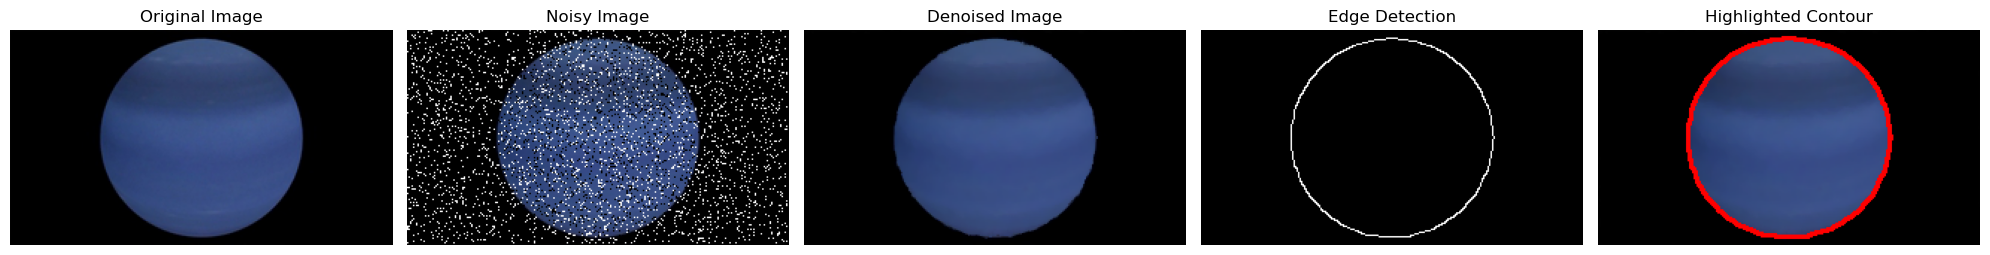

In [59]:
def show_planet_detection(image):
    # Aplicar ruido a la imagen
    noisy_image = add_salt_pepper(image, salt_probability=0.03, pepper_probability=0.03)

    denoised_image_median, edges, highlighted_image = planet_detection_pipeline(noisy_image)

    # Mostrar todas las imágenes en una cuadrícula de una fila
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Noisy Image")
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(denoised_image_median, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Denoised Image")
    axs[2].axis('off')

    axs[3].imshow(edges, cmap='gray')
    axs[3].set_title("Edge Detection")
    axs[3].axis('off')

    axs[4].imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    axs[4].set_title("Highlighted Contour")
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()

show_planet_detection(cv2.imread('data/planet1.jpg'))
show_planet_detection(cv2.imread('data/planet2.jpg'))
show_planet_detection(cv2.imread('data/planet3.jpg'))